Velg datasett (plateau / gaussian / sinusoidal):


>>  gaussian


Episode 1, Total Loss: 1.6587


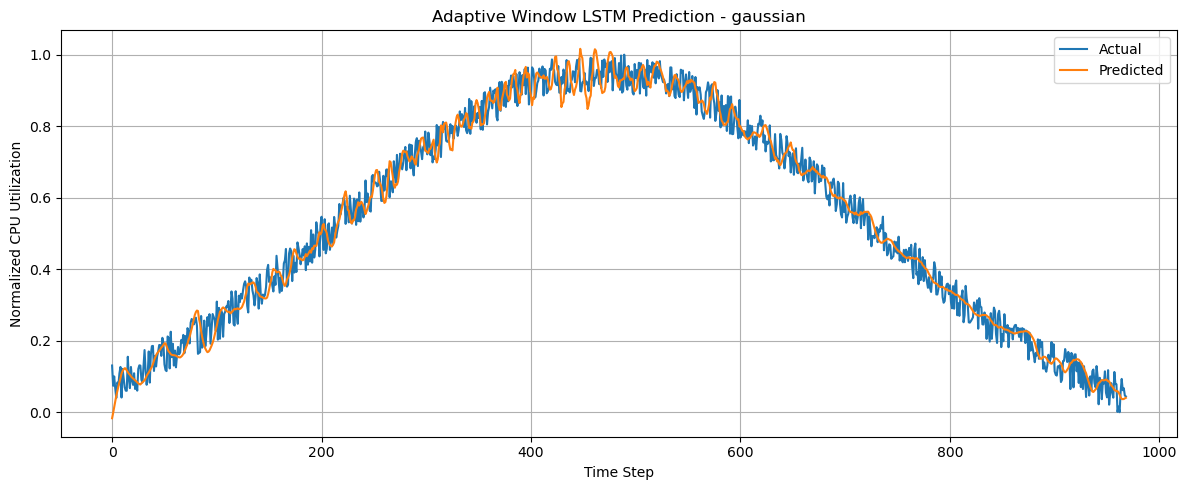

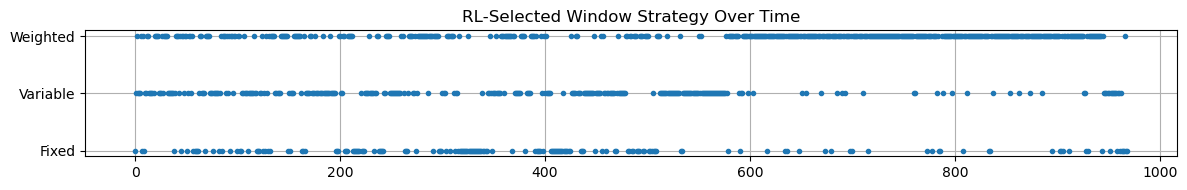

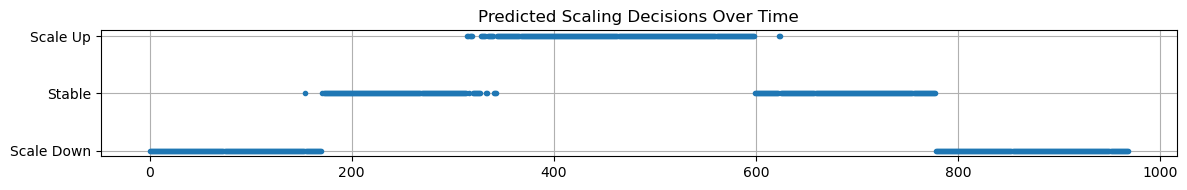

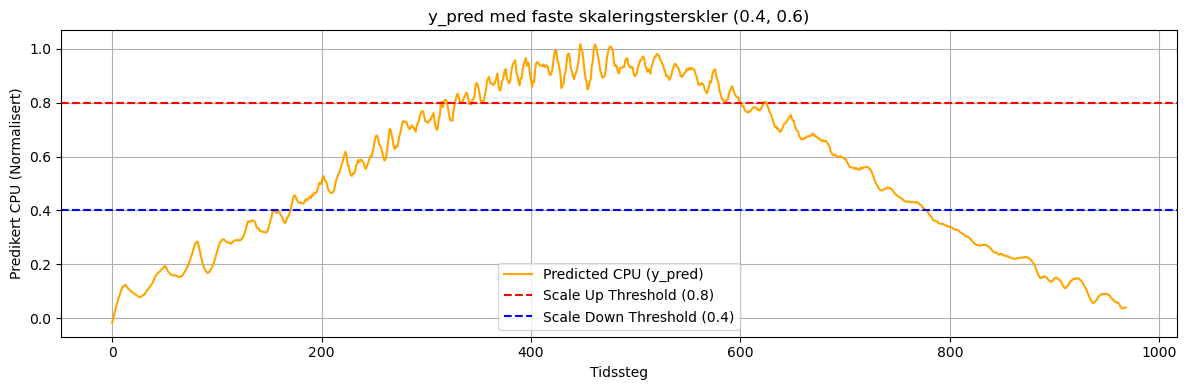

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/adaptive_window_fixed_thresholds.py'

In [ ]:
# ============================================================
# Adaptive Sliding Window + LSTM + RL Model with Scaling Actions. Basically 
# ============================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

print("Velg datasett (plateau / gaussian / sinusoidal):")
choice = input(">> ").strip().lower()

file_map = {
    "plateau": "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/Newest addition/Plateu/plateau_log.csv",
    "gaussian": "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/Newest addition/Gausian curve/gaussian_curve_fixed.csv",
    "sinusoidal": "/Users/biraveennedunchelian/Documents/Masteroppgave/Masteroppgave/Newest addition/sinusoid curve/sinusoidal_log.csv"
}

if choice not in file_map: #egt bare for å sjekke om jeg kan gi feil data
    print("Ugyldig valg.")
    exit()

filename = file_map[choice] # kun for å sjekke om jeg kan gi filer som ikke eksisterer
if not os.path.exists(filename):
    print(f"Filen '{filename}' ble ikke funnet i mappen.")
    exit()

df = pd.read_csv(filename)
scaler = MinMaxScaler()
normalized = scaler.fit_transform(df[['Y']].values).astype(np.float32)

def fixed_window(data, idx, size=20): #fixed window
    if idx < size: return data[0:idx+1]
    return data[idx-size+1:idx+1]

def variable_window(data, idx, min_size=10, max_size=30): #variable window lengh
    size = random.randint(min_size, max_size)
    if idx < size: return data[0:idx+1]
    return data[idx-size+1:idx+1]

def weighted_window(data, idx, size=20): #weighted average window, bruker fixed windows
    if idx < size: window = data[0:idx+1]
    else: window = data[idx-size+1:idx+1]
    weights = np.linspace(0.1, 1.0, len(window)).reshape(-1, 1)
    return window * weights

#Dette definerer vår LSTM Modell og gjør det predicitons liksom
class LSTMModel(nn.Module): 
    def __init__(self, input_size=1, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x) #prosessere the input sequence
        return self.fc(hn[-1])  #den siste hidden staten av LSTM (representerer hele sekvensen)

model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

Q = np.zeros((3,)) #representerer Q strategi (0 = fixed, 1 = variable, 2 = weighted)
epsilon = 0.2 #hvor stor sjanse for at den eksprerimentere og tester en annnen strategi 
alpha = 0.1 #hvor mye ny erfaring påvirker q verdien, så med at vi har 0.1 betyr det at Q verdien tar 10prosent av den nye versionen og beholder 90prosetn
gamma = 0.9 #hvor mye agenten bryr seg om fremdidige belønninger, med gamma på 0.9 så betyr det at "ta med 90 % av den høyeste fremtidige Q-verdien i beregningen nå"

episodes = 1 #hvor mange ganger iterasjoner det er snakk om 
predictions, actuals, actions_taken, scale_decisions = [], [], [], []

# Bruk faste terskler direkte (0.4 og 0.8)
low_thresh = 0.4
high_thresh = 0.8

for ep in range(episodes): #iterasjoner 
    total_loss = 0
    for t in range(30, len(normalized)-1):
        if random.random() < epsilon: # basically (try random strategy) vs. exploitation (use best Q-value so far)
            action = random.randint(0, 2)
        else:
            action = int(np.argmax(Q))

        if action == 0: #her velger den hvilken sliding window 
            window = fixed_window(normalized, t)
        elif action == 1:
            window = variable_window(normalized, t)
        else:
            window = weighted_window(normalized, t)

        x = torch.tensor(window, dtype=torch.float32) #prepper input for LSTM modellen
        if x.ndim == 1:
            x = x.unsqueeze(0).unsqueeze(-1)
        elif x.ndim == 2:
            x = x.unsqueeze(0)

        y_true = torch.tensor(normalized[t+1], dtype=torch.float32).unsqueeze(0)
        y_pred = model(x) #prøver å predikere the next cpu usage verdi
        loss = loss_fn(y_pred, y_true) #ong basically compares prediction to actual (MSE loss)
        total_loss += loss.item() #yall ready know B)

        optimizer.zero_grad() #standard pytorch training
        loss.backward() #standard pytorch training
        optimizer.step() #standard pytorch training

        reward = -loss.item() #straffen elelr belønningen skjer her, liksom jo lavere loss jo høyere reward
        Q[action] = Q[action] + alpha * (reward + gamma * np.max(Q) - Q[action]) #dette oppdaterer Q verdien for den valgte stragien, ved bruk av en q formel 

        predictions.append(y_pred.item()) #lagrer prediktions, faktiske verdier og hvilket strategi som ble brukt
        actuals.append(y_true.item())
        actions_taken.append(action)

        if y_pred.item() > high_thresh: #mekker skalrings decisions
            scale_decisions.append(1)
        elif y_pred.item() < low_thresh:
            scale_decisions.append(-1)
        else:
            scale_decisions.append(0)

    print(f"Episode {ep+1}, Total Loss: {total_loss:.4f}") #tracker performance per ep og golder oss oppdatert så du vet at den ikke har hengt seg opp og kjører i 1000+år

plt.figure(figsize=(12, 5))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title(f"Adaptive Window LSTM Prediction - {choice}")
plt.xlabel("Time Step")
plt.ylabel("Normalized CPU Utilization")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(actions_taken, '.', label='Action (0=Fixed, 1=Variable, 2=Weighted)')
plt.yticks([0, 1, 2], ['Fixed', 'Variable', 'Weighted'])
plt.title("RL-Selected Window Strategy Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 2))
plt.plot(scale_decisions, '.', label='Scaling Action')
plt.yticks([-1, 0, 1], ['Scale Down', 'Stable', 'Scale Up'])
plt.title("Predicted Scaling Decisions Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(predictions, label='Predicted CPU (y_pred)', color='orange')
plt.axhline(y=high_thresh, color='red', linestyle='--', label='Scale Up Threshold (0.8)')
plt.axhline(y=low_thresh, color='blue', linestyle='--', label='Scale Down Threshold (0.4)')
plt.title("y_pred med faste skaleringsterskler (0.4, 0.8)")
plt.xlabel("Tidssteg")
plt.ylabel("Predikert CPU (Normalisert)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Lagre oppdatert versjon
#fixed_threshold_script_path = "/mnt/data/adaptive_window_fixed_thresholds.py"
#with open(fixed_threshold_script_path, "w") as f:
#    f.write(script_with_fixed_thresholds)

fixed_threshold_script_path
